## Regression with a Crab Age Dataset
## Junfei Ma | Crystal Cui | Shuangqing Li | Chengcheng Le

### https://www.kaggle.com/competitions/playground-series-s3e16


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.base import BaseEstimator, TransformerMixin
from sklego.linear_model import LADRegression
from flaml import AutoML

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [3]:
train

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8
...,...,...,...,...,...,...,...,...,...,...
74046,74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10
74047,74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6
74048,74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10
74049,74049,I,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8


In [4]:
test

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066
...,...,...,...,...,...,...,...,...,...
49363,123414,F,1.3000,1.0375,0.3250,16.315137,6.690482,5.173784,3.756309
49364,123415,I,1.0375,0.7625,0.2625,10.276694,4.436697,1.998640,3.543687
49365,123416,F,1.4875,1.1625,0.3625,31.382897,11.396499,6.846404,8.788345
49366,123417,F,1.2375,0.9500,0.2875,15.663099,6.095142,3.727959,4.961163


## Data Exploration

In [5]:
train.nunique()

id                74051
Sex                   3
Length              144
Diameter            122
Height               65
Weight             3096
Shucked Weight     1766
Viscera Weight      967
Shell Weight       1048
Age                  28
dtype: int64

In [6]:
train.isnull().sum(), test.isnull().sum()

(id                0
 Sex               0
 Length            0
 Diameter          0
 Height            0
 Weight            0
 Shucked Weight    0
 Viscera Weight    0
 Shell Weight      0
 Age               0
 dtype: int64,
 id                0
 Sex               0
 Length            0
 Diameter          0
 Height            0
 Weight            0
 Shucked Weight    0
 Viscera Weight    0
 Shell Weight      0
 dtype: int64)

In [7]:
train.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [8]:
test.describe()

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,98734.500000,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876
std,14251.458382,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650
min,74051.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524
25%,86392.750000,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930
50%,98734.500000,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627
75%,111076.250000,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063
max,123418.000000,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248


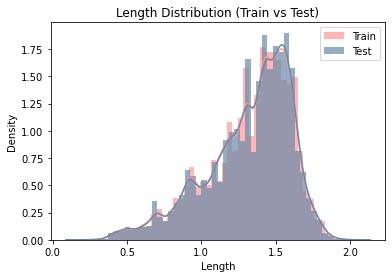

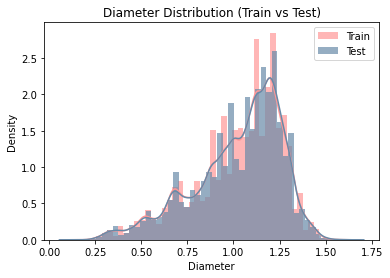

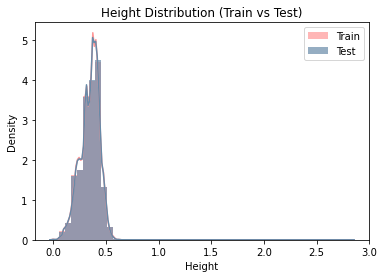

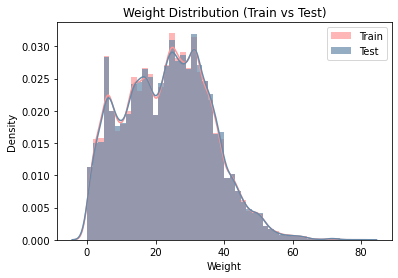

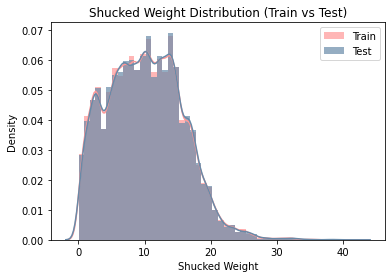

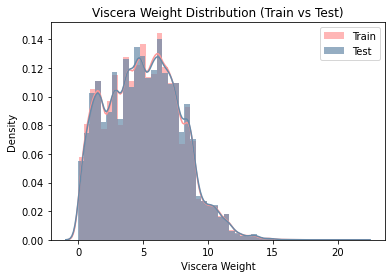

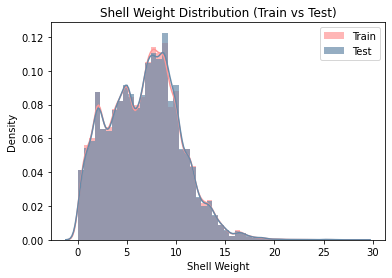

In [9]:
target_columns = ['Length','Diameter','Height', 'Weight','Shucked Weight', 'Viscera Weight', 'Shell Weight']

for c in target_columns:
    sns.distplot(train[c], kde=True, label='Train', color= '#FF9797', hist_kws={'alpha': 0.7})
    sns.distplot(test[c], kde=True, label='Test', color='#688AA8',hist_kws={'alpha': 0.7})
    plt.title(f"{c} Distribution (Train vs Test)")
    # Display the legend
    plt.legend()

    plt.show()

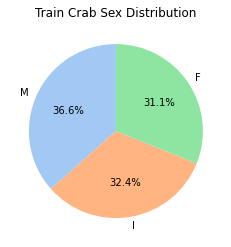

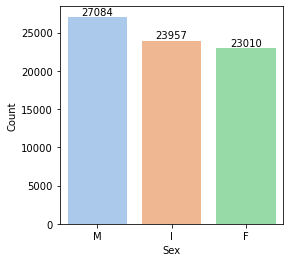

In [10]:
train_sex_counts = train['Sex'].value_counts()

#Pie chart
plt.figure(figsize=(4, 4))  
colors = sns.color_palette("pastel")
plt.pie(train_sex_counts, labels=train_sex_counts.index, autopct='%1.1f%%', startangle=90, colors = colors)
plt.title('Train Crab Sex Distribution')

# bar chart
plt.figure(figsize=(4, 4))
colors = sns.color_palette("pastel")
train_bar = sns.barplot(x = train_sex_counts.index, y =train_sex_counts, palette = colors)

for i, count in enumerate(train_sex_counts):
    train_bar.text(i, count, str(count), ha='center', va='bottom')

plt.xlabel('Sex')
plt.ylabel('Count')


plt.show()

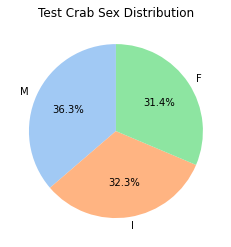

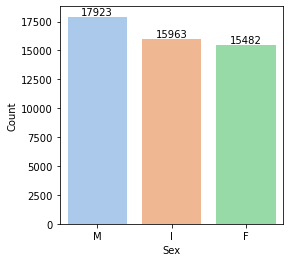

In [11]:
test_sex_counts = test['Sex'].value_counts()

#Pie chart
plt.figure(figsize=(4, 4))  # Set the figure size
colors = sns.color_palette("pastel")
plt.pie(test_sex_counts, labels=test_sex_counts.index, autopct='%1.1f%%', startangle=90,colors = colors)
plt.title('Test Crab Sex Distribution')

#Bar chart
plt.figure(figsize=(4, 4))  # Set the figure size
colors = sns.color_palette("pastel")
test_bar = sns.barplot(x = test_sex_counts.index, y =test_sex_counts, palette = colors)

for i, count in enumerate(test_sex_counts):
    test_bar.text(i, count, str(count), ha='center', va='bottom')

plt.xlabel('Sex')
plt.ylabel('Count')

plt.show()

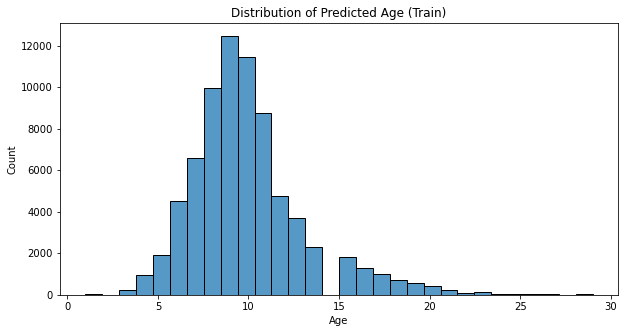

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(train['Age'], bins=30)
plt.title('Distribution of Predicted Age (Train)')
plt.show()

<AxesSubplot:>

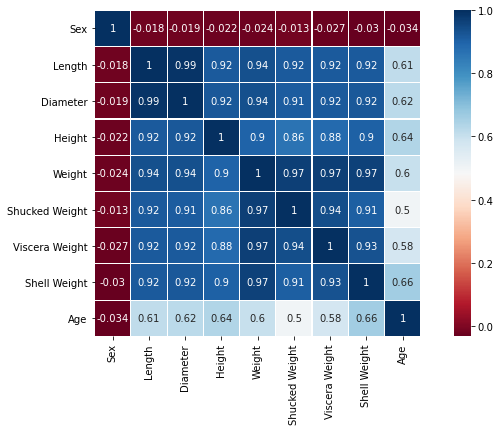

In [13]:
# check data characteristics
# correlation between features in train-data
train_cor = train.drop(['id'], axis=1)
label_encoder = LabelEncoder()
train_cor['Sex'] = label_encoder.fit_transform(train_cor['Sex'])
plt.figure(figsize=(12, 6))
colormap = plt.cm.RdBu
sns.heatmap(train_cor.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white", annot=True)

## Data cleaning&Processing

#### Height = 0

In [14]:
train.loc[(train['Height'] == 0)]

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
762,762,I,0.787500,0.5750,0.0,3.727959,1.417475,0.807961,1.133980,4
3585,3585,I,0.737087,0.5250,0.0,2.267960,0.737087,0.652038,0.708738,5
8749,8749,I,0.525000,0.3750,0.0,2.863300,1.204854,0.425243,0.425243,4
9320,9320,I,0.462500,0.3250,0.0,0.893009,0.354369,0.141747,0.269320,7
11542,11542,I,0.637500,0.4375,0.0,1.771844,0.637864,0.396893,0.462525,3
13456,13456,I,0.575000,0.4000,0.0,1.304077,0.467767,0.340194,0.382718,3
14406,14406,I,0.737500,0.5375,0.0,3.515338,1.630096,0.737087,0.878834,2
15463,15463,I,0.500000,0.4000,0.0,1.318252,0.411068,0.226796,0.283495,4
16301,16301,I,0.437500,0.3625,0.0,1.077281,0.467767,0.184272,0.255146,4
28362,28362,I,0.387500,0.2625,0.0,0.496116,0.141747,0.099223,0.141747,3


In [15]:
test.loc[(test['Height'] == 0)].sort_values(by = ['Weight'])

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
45152,119203,I,0.4750,0.3250,0.0,0.751262,0.255146,0.155922,0.255146
26879,100930,I,0.4000,0.3000,0.0,0.907184,0.311845,0.212621,0.283495
42238,116289,I,0.5625,0.4250,0.0,1.318252,0.708738,0.425243,0.425243
31053,105104,I,0.5625,0.4250,0.0,1.630096,1.105630,0.184272,0.425243
44472,118523,I,0.5875,0.4250,0.0,1.800193,0.751262,0.226796,0.496116
41972,116023,I,0.5500,0.4000,0.0,1.828543,0.609514,0.354369,0.510291
18951,93002,I,0.5875,0.4000,0.0,1.998640,0.949708,0.340194,0.425243
36603,110654,M,0.7250,0.5625,0.0,2.764076,1.516698,0.623689,0.850485
9726,83777,I,0.7375,0.5500,0.0,3.869707,1.630096,0.807961,9.936500
15146,89197,I,0.7500,0.5750,0.0,3.940580,1.601747,0.807961,1.190679


#### Prdecit Height

In [16]:
data_id = train[(train['Height'] == 0)]
height_id = data_id['id']

In [17]:
train_new = train.copy()

data_sex_i = train_new[train_new['Sex'] == 'I']
data_sex_i = data_sex_i.drop(['id','Sex','Age'],axis=1)

data_nonzero = data_sex_i[data_sex_i['Height'] != 0]
data_zero = data_sex_i[data_sex_i['Height'] == 0]

In [18]:
X_train = data_nonzero.drop('Height', axis=1)
y_train = data_nonzero['Height']

# Create an XGBoostRegressor model
rf = RandomForestRegressor(random_state=42)
# Fit the model to the non-zero data
rf.fit(X_train, y_train)

# Make predictions for the zero values
X_zero = data_zero.drop('Height', axis=1)
y_pred = rf.predict(X_zero)

In [19]:
updated_train = train.copy()

# Create a mask for the cells that were predicted (where the value is 0)
mask = updated_train['Height'] == 0

# Update the values in the predicted cells with the corresponding predicted values
updated_train.loc[mask, 'Height'] = y_pred

In [20]:
test_new = test.copy()
test_new = test_new.drop(['id','Sex'],axis=1)

data_nonzero = test_new[test_new['Height'] != 0]
data_zero = test_new[test_new['Height'] == 0]

X_zero = data_zero.drop('Height', axis=1)
y_pred = rf.predict(X_zero)

In [21]:
updated_test = test.copy()

# Create a mask for the cells that were predicted (where the value is 0)
mask = updated_test['Height'] == 0

# Update the values in the predicted cells with the corresponding predicted values
updated_test.loc[mask, 'Height'] = y_pred
updated_test

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066
...,...,...,...,...,...,...,...,...,...
49363,123414,F,1.3000,1.0375,0.3250,16.315137,6.690482,5.173784,3.756309
49364,123415,I,1.0375,0.7625,0.2625,10.276694,4.436697,1.998640,3.543687
49365,123416,F,1.4875,1.1625,0.3625,31.382897,11.396499,6.846404,8.788345
49366,123417,F,1.2375,0.9500,0.2875,15.663099,6.095142,3.727959,4.961163


## Modeling

In [22]:
train = updated_train.copy()
test = updated_test.copy()

In [23]:
X = train.drop(columns=['id','Age'])
y = train['Age']

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']),
    ('cat', OneHotEncoder(), ['Sex'])])

In [26]:
rf = RandomForestRegressor(random_state=42)
xgb = xgb.XGBRegressor(random_state=42)
lgbm = lgb.LGBMRegressor(random_state=42)
cat = CatBoostRegressor(random_state=42)

In [27]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', rf)])

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb)])

lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lgbm)])

cat_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', cat)])

In [28]:
rf_params = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
    'regressor__max_features': ['auto', 'sqrt'],
    'regressor__max_depth': [10, 20, 30, 40, 50, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__bootstrap': [True, False]
}

In [29]:
xgb_params = {
    'regressor__n_estimators': [50, 100, 200, 300, 400, 500],
    'regressor__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'regressor__max_depth': [2, 3, 5, 7, 9, 11],
    'regressor__subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__min_child_weight': [1, 3, 5, 7, 10],
    'regressor__gamma': [0, 0.5, 1, 1.5, 2, 2.5, 3],
    'regressor__scale_pos_weight': [1, 10, 25, 50, 75, 100],
    'regressor__reg_alpha': [0, 0.1, 0.5, 1, 1.5, 2],
    'regressor__reg_lambda': [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
}

In [30]:
lgbm_params = {
    'regressor__num_leaves': [7, 14, 31, 62],
    'regressor__max_depth': [3, 4, 5, 6, -1],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__n_estimators': [200, 400, 600, 800],
    'regressor__subsample_for_bin': [20000, 50000, 100000, 200000],
    'regressor__min_split_gain': [0, 0.001, 0.01],
    'regressor__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'regressor__subsample': [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

In [31]:
cat_params = {
    'regressor__iterations': [100, 200, 300, 500],
    'regressor__depth': [4, 5, 6, 7, 8, 9, 10],
    'regressor__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
    'regressor__l2_leaf_reg': [1, 3, 5, 7, 9],
    'regressor__border_count': [32, 5, 10, 20, 50, 100, 200],
    'regressor__loss_function': ['RMSE', 'MAE', 'Quantile']
}

In [32]:
#Random forest grid search will take very long time to run
#Comment out for performing a gird search
"""
# Start the timer
start_time = time.time()

rf_random_search = RandomizedSearchCV(rf_pipeline, rf_params, n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42)
rf_random_search.fit(X_train, y_train)

# End the timer and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

minutes, seconds = divmod(elapsed_time, 60)
print("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))
print(" ")
print(f"Best parameters for RandomForest: {rf_random_search.best_params_}")
"""

'\n# Start the timer\nstart_time = time.time()\n\nrf_random_search = RandomizedSearchCV(rf_pipeline, rf_params, n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42)\nrf_random_search.fit(X_train, y_train)\n\n# End the timer and print the elapsed time\nend_time = time.time()\nelapsed_time = end_time - start_time\n\nminutes, seconds = divmod(elapsed_time, 60)\nprint("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))\nprint(" ")\nprint(f"Best parameters for RandomForest: {rf_random_search.best_params_}")\n'

Time taken for Randomized Search: 51 minutes 53 seconds

In [33]:
#Store information for last grid search for rf
rf = RandomForestRegressor(n_estimators=400,
                           min_samples_split=10,
                           min_samples_leaf=4,
                           max_features='sqrt',
                           max_depth=20,
                           bootstrap=True,
                           random_state=42)

In [34]:
# Start the timer
start_time = time.time()

xgb_random_search = RandomizedSearchCV(xgb_pipeline, xgb_params, n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42)
xgb_random_search.fit(X_train, y_train)

# End the timer and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

minutes, seconds = divmod(elapsed_time, 60)
print("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))
print(" ")
print(f"Best parameters for XGBoost: {xgb_random_search.best_params_}")


Time taken for Randomized Search: 6 minutes 9 seconds
 
Best parameters for XGBoost: {'regressor__subsample': 0.8, 'regressor__scale_pos_weight': 50, 'regressor__reg_lambda': 4, 'regressor__reg_alpha': 0, 'regressor__n_estimators': 400, 'regressor__min_child_weight': 7, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__gamma': 1, 'regressor__colsample_bytree': 0.8}


In [35]:
#Comment out for performing a gird search

# Start the timer
start_time = time.time()

lgbm_random_search = RandomizedSearchCV(lgbm_pipeline, lgbm_params, n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42)
lgbm_random_search.fit(X_train, y_train)

# End the timer and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time


minutes, seconds = divmod(elapsed_time, 60)
print("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))
print(" ")
print(f"Best parameters for LGMB: {lgbm_random_search.best_params_}")


Time taken for Randomized Search: 1 minutes 5 seconds
 
Best parameters for LGMB: {'regressor__subsample_for_bin': 20000, 'regressor__subsample': 0.6, 'regressor__num_leaves': 7, 'regressor__n_estimators': 800, 'regressor__min_split_gain': 0.001, 'regressor__min_child_weight': 100.0, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.8}


In [36]:
#Comment out for performing a gird search

# Start the timer
start_time = time.time()

cat_random_search = RandomizedSearchCV(cat_pipeline, cat_params, n_iter=100, cv=5, verbose=0, n_jobs=-1, random_state=42)
cat_random_search.fit(X_train, y_train)

# End the timer and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

minutes, seconds = divmod(elapsed_time, 60)
print("Time taken for Randomized Search: %d minutes %d seconds" % (minutes, seconds))
print(" ")
print(f"Best parameters for CatBoost: {cat_random_search.best_params_}")


0:	learn: 3.0313097	total: 57.2ms	remaining: 28.6s
1:	learn: 2.9113544	total: 60.1ms	remaining: 15s
2:	learn: 2.8079794	total: 62.7ms	remaining: 10.4s
3:	learn: 2.7193815	total: 65.1ms	remaining: 8.07s
4:	learn: 2.6389075	total: 67.6ms	remaining: 6.69s
5:	learn: 2.5732860	total: 70.1ms	remaining: 5.77s
6:	learn: 2.5159284	total: 72.5ms	remaining: 5.11s
7:	learn: 2.4675598	total: 74.9ms	remaining: 4.61s
8:	learn: 2.4267597	total: 77.5ms	remaining: 4.22s
9:	learn: 2.3913727	total: 80ms	remaining: 3.92s
10:	learn: 2.3590056	total: 82.6ms	remaining: 3.67s
11:	learn: 2.3323982	total: 85.2ms	remaining: 3.46s
12:	learn: 2.3068527	total: 87.9ms	remaining: 3.29s
13:	learn: 2.2878284	total: 90.4ms	remaining: 3.14s
14:	learn: 2.2687241	total: 93.2ms	remaining: 3.01s
15:	learn: 2.2499730	total: 95.8ms	remaining: 2.9s
16:	learn: 2.2348657	total: 98.4ms	remaining: 2.79s
17:	learn: 2.2234061	total: 101ms	remaining: 2.7s
18:	learn: 2.2121595	total: 104ms	remaining: 2.63s
19:	learn: 2.2025376	total: 10

216:	learn: 2.0222357	total: 577ms	remaining: 753ms
217:	learn: 2.0219749	total: 580ms	remaining: 750ms
218:	learn: 2.0216407	total: 582ms	remaining: 747ms
219:	learn: 2.0213292	total: 584ms	remaining: 744ms
220:	learn: 2.0210183	total: 587ms	remaining: 741ms
221:	learn: 2.0206443	total: 590ms	remaining: 739ms
222:	learn: 2.0205115	total: 592ms	remaining: 735ms
223:	learn: 2.0202002	total: 595ms	remaining: 733ms
224:	learn: 2.0197635	total: 597ms	remaining: 729ms
225:	learn: 2.0194166	total: 599ms	remaining: 726ms
226:	learn: 2.0193475	total: 601ms	remaining: 723ms
227:	learn: 2.0192358	total: 603ms	remaining: 720ms
228:	learn: 2.0189304	total: 606ms	remaining: 717ms
229:	learn: 2.0186635	total: 608ms	remaining: 713ms
230:	learn: 2.0184351	total: 610ms	remaining: 710ms
231:	learn: 2.0180953	total: 612ms	remaining: 707ms
232:	learn: 2.0179131	total: 614ms	remaining: 704ms
233:	learn: 2.0176038	total: 617ms	remaining: 701ms
234:	learn: 2.0172924	total: 619ms	remaining: 698ms
235:	learn: 

443:	learn: 1.9782998	total: 1.11s	remaining: 140ms
444:	learn: 1.9782046	total: 1.11s	remaining: 137ms
445:	learn: 1.9781398	total: 1.11s	remaining: 135ms
446:	learn: 1.9780561	total: 1.11s	remaining: 132ms
447:	learn: 1.9780547	total: 1.12s	remaining: 130ms
448:	learn: 1.9778973	total: 1.12s	remaining: 127ms
449:	learn: 1.9777434	total: 1.12s	remaining: 125ms
450:	learn: 1.9777212	total: 1.13s	remaining: 122ms
451:	learn: 1.9774837	total: 1.13s	remaining: 120ms
452:	learn: 1.9773021	total: 1.13s	remaining: 117ms
453:	learn: 1.9771162	total: 1.13s	remaining: 115ms
454:	learn: 1.9769545	total: 1.13s	remaining: 112ms
455:	learn: 1.9768575	total: 1.14s	remaining: 110ms
456:	learn: 1.9766520	total: 1.14s	remaining: 107ms
457:	learn: 1.9765833	total: 1.14s	remaining: 105ms
458:	learn: 1.9765675	total: 1.14s	remaining: 102ms
459:	learn: 1.9764227	total: 1.15s	remaining: 99.6ms
460:	learn: 1.9762986	total: 1.15s	remaining: 97.1ms
461:	learn: 1.9761521	total: 1.15s	remaining: 94.6ms
462:	lear

In [37]:
"""

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', rf)])

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', xgb)])

lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lgbm)])

cat_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', cat)])
"""                       

"\n\nrf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),\n                               ('regressor', rf)])\n\nxgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),\n                               ('regressor', xgb)])\n\nlgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),\n                               ('regressor', lgbm)])\n\ncat_pipeline = Pipeline(steps=[('preprocessor', preprocessor),\n                               ('regressor', cat)])\n"

In [38]:
"""
pipelines = [rf_pipeline, xgb_pipeline, lgbm_pipeline, cat_pipeline]


num_folds = 10  # Number of cross-validation folds

# Perform cross-validation and store R-squared scores
scores = []
for pipeline, model_name in zip(pipelines):
    model_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring='r2')
    scores.append(model_scores)

scores
"""

"\npipelines = [rf_pipeline, xgb_pipeline, lgbm_pipeline, cat_pipeline]\n\n\nnum_folds = 10  # Number of cross-validation folds\n\n# Perform cross-validation and store R-squared scores\nscores = []\nfor pipeline, model_name in zip(pipelines):\n    model_scores = cross_val_score(pipeline, X, y, cv=num_folds, scoring='r2')\n    scores.append(model_scores)\n\nscores\n"

In [39]:
scores = [
    [0.5810072, 0.58763956, 0.58822255, 0.58621534, 0.58275919,
     0.59589913, 0.58201326, 0.5719473, 0.59583001, 0.55914274],
    [0.58282471, 0.59189613, 0.59528336, 0.59018996, 0.58866753,
     0.60233839, 0.58684222, 0.57512217, 0.59782599, 0.5651888],
    [0.58490538, 0.59052942, 0.59331061, 0.59215291, 0.58832854,
     0.60576346, 0.58838484, 0.5775467, 0.59902527, 0.56518318],
    [0.58437871, 0.5917907, 0.59527333, 0.59100577, 0.58796248,
     0.60251697, 0.58703767, 0.57491664, 0.59713046, 0.56378949]
]

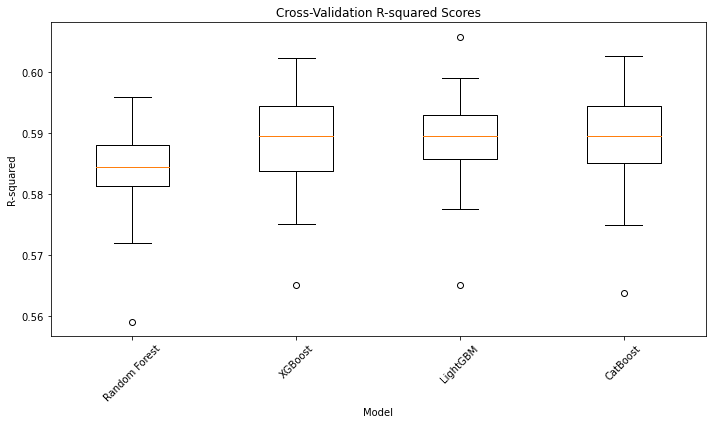

In [40]:
# Plotting the results
models = ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(scores, labels=models)
ax.set_xlabel('Model')
ax.set_ylabel('R-squared')
ax.set_title('Cross-Validation R-squared Scores')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
test_ids = test['id']
X_test = test.drop(columns=['id'])

In [42]:
best_params = xgb_random_search.best_params_
best_xgb_pipeline = xgb_pipeline.set_params(**best_params)
best_xgb_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Weight',
                                                   'Shucked Weight',
                                                   'Viscera Weight',
                                                   'Shell Weight']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex'])])),
                ('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.8, early_s...
                              feature_types=None, gamma=1, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='', learning_rate=0.05,
                              max_bin=256, max_cat_threshold=64,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=5, max_leaves=0, min_child_weight=7,
                              missing=nan, monotone_constraints='()',
                              n_estimators=400, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=42, ...))])

In [43]:
y_test_pred = best_xgb_pipeline.predict(X_test)

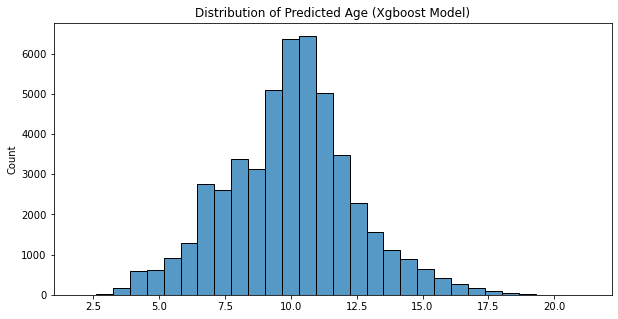

In [44]:
plt.figure(figsize=(10, 5))
sns.histplot(y_test_pred, bins=30)
plt.title('Distribution of Predicted Age (Xgboost Model)')
plt.show()

In [45]:
submission = pd.DataFrame({
    'id': test_ids,
    'Age': y_test_pred
})
submission.to_csv("xgb.csv", index = False)

### Ensemble Model

In [46]:
voting_model = VotingRegressor([
    ('xgb', xgb_random_search.best_estimator_),
    ('lgbm', lgbm_random_search.best_estimator_),
    ('cat', cat_random_search.best_estimator_)
])

# Fit the model to the training data
voting_model.fit(X, y)

# Make predictions on the validation data
y_test_pred = voting_model.predict(X_test)


0:	learn: 3.0347244	total: 3.91ms	remaining: 1.95s
1:	learn: 2.9150194	total: 7.05ms	remaining: 1.76s
2:	learn: 2.8136279	total: 9.81ms	remaining: 1.62s
3:	learn: 2.7245288	total: 12.8ms	remaining: 1.59s
4:	learn: 2.6473998	total: 15.7ms	remaining: 1.55s
5:	learn: 2.5784715	total: 18.6ms	remaining: 1.53s
6:	learn: 2.5208206	total: 21.5ms	remaining: 1.51s
7:	learn: 2.4736330	total: 24.3ms	remaining: 1.49s
8:	learn: 2.4306330	total: 27.2ms	remaining: 1.48s
9:	learn: 2.3947097	total: 29.9ms	remaining: 1.47s
10:	learn: 2.3649478	total: 32.6ms	remaining: 1.45s
11:	learn: 2.3376804	total: 35.3ms	remaining: 1.43s
12:	learn: 2.3140121	total: 38.3ms	remaining: 1.44s
13:	learn: 2.2918311	total: 41ms	remaining: 1.42s
14:	learn: 2.2737092	total: 43.9ms	remaining: 1.42s
15:	learn: 2.2548710	total: 46.9ms	remaining: 1.42s
16:	learn: 2.2415349	total: 50.3ms	remaining: 1.43s
17:	learn: 2.2292715	total: 53.3ms	remaining: 1.43s
18:	learn: 2.2176300	total: 56ms	remaining: 1.42s
19:	learn: 2.2077698	total

202:	learn: 2.0240347	total: 537ms	remaining: 786ms
203:	learn: 2.0238235	total: 540ms	remaining: 783ms
204:	learn: 2.0234769	total: 543ms	remaining: 782ms
205:	learn: 2.0231207	total: 546ms	remaining: 779ms
206:	learn: 2.0228063	total: 549ms	remaining: 777ms
207:	learn: 2.0227885	total: 552ms	remaining: 774ms
208:	learn: 2.0225172	total: 554ms	remaining: 772ms
209:	learn: 2.0225002	total: 557ms	remaining: 769ms
210:	learn: 2.0221986	total: 559ms	remaining: 766ms
211:	learn: 2.0219000	total: 562ms	remaining: 764ms
212:	learn: 2.0218382	total: 565ms	remaining: 761ms
213:	learn: 2.0217116	total: 568ms	remaining: 759ms
214:	learn: 2.0213936	total: 571ms	remaining: 757ms
215:	learn: 2.0209755	total: 574ms	remaining: 754ms
216:	learn: 2.0209448	total: 576ms	remaining: 752ms
217:	learn: 2.0207801	total: 579ms	remaining: 749ms
218:	learn: 2.0206215	total: 582ms	remaining: 746ms
219:	learn: 2.0202933	total: 584ms	remaining: 744ms
220:	learn: 2.0200531	total: 587ms	remaining: 741ms
221:	learn: 

393:	learn: 1.9929603	total: 1.06s	remaining: 286ms
394:	learn: 1.9928418	total: 1.07s	remaining: 284ms
395:	learn: 1.9926764	total: 1.07s	remaining: 281ms
396:	learn: 1.9925249	total: 1.07s	remaining: 279ms
397:	learn: 1.9923648	total: 1.08s	remaining: 276ms
398:	learn: 1.9921961	total: 1.08s	remaining: 273ms
399:	learn: 1.9921049	total: 1.08s	remaining: 270ms
400:	learn: 1.9919613	total: 1.08s	remaining: 268ms
401:	learn: 1.9917914	total: 1.09s	remaining: 265ms
402:	learn: 1.9917693	total: 1.09s	remaining: 263ms
403:	learn: 1.9916390	total: 1.09s	remaining: 260ms
404:	learn: 1.9915146	total: 1.1s	remaining: 257ms
405:	learn: 1.9913426	total: 1.1s	remaining: 255ms
406:	learn: 1.9913158	total: 1.1s	remaining: 252ms
407:	learn: 1.9911527	total: 1.1s	remaining: 249ms
408:	learn: 1.9909940	total: 1.11s	remaining: 246ms
409:	learn: 1.9909264	total: 1.11s	remaining: 244ms
410:	learn: 1.9909099	total: 1.11s	remaining: 241ms
411:	learn: 1.9907504	total: 1.11s	remaining: 238ms
412:	learn: 1.99

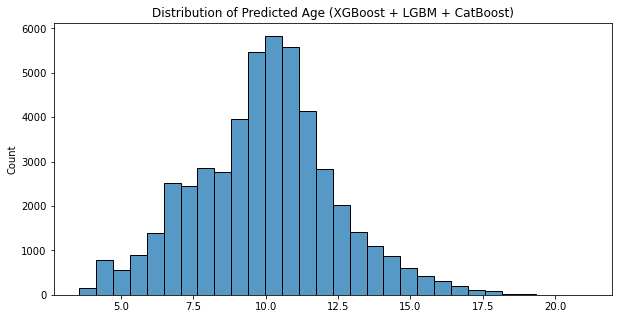

In [47]:
plt.figure(figsize=(10, 5))
sns.histplot(y_test_pred , bins=30)
plt.title('Distribution of Predicted Age (XGBoost + LGBM + CatBoost)')
plt.show()

In [48]:
submission = pd.DataFrame({
    'id': test_ids,
    'Age': y_test_pred
})
submission.to_csv("voting_model_1.csv", index = False)

In [49]:
voting_model = VotingRegressor([
    ('xgb', xgb_random_search.best_estimator_),
    ('cat', cat_random_search.best_estimator_)
])

# Fit the model to the training data
voting_model.fit(X, y)

# Make predictions on the validation data
y_test_pred = voting_model.predict(X_test)

0:	learn: 3.0347244	total: 3.38ms	remaining: 1.69s
1:	learn: 2.9150194	total: 6.5ms	remaining: 1.62s
2:	learn: 2.8136279	total: 9.39ms	remaining: 1.55s
3:	learn: 2.7245288	total: 12.3ms	remaining: 1.52s
4:	learn: 2.6473998	total: 15.2ms	remaining: 1.5s
5:	learn: 2.5784715	total: 17.9ms	remaining: 1.48s
6:	learn: 2.5208206	total: 20.9ms	remaining: 1.47s
7:	learn: 2.4736330	total: 23.6ms	remaining: 1.45s
8:	learn: 2.4306330	total: 26.4ms	remaining: 1.44s
9:	learn: 2.3947097	total: 29.2ms	remaining: 1.43s
10:	learn: 2.3649478	total: 31.9ms	remaining: 1.42s
11:	learn: 2.3376804	total: 34.5ms	remaining: 1.4s
12:	learn: 2.3140121	total: 37.5ms	remaining: 1.4s
13:	learn: 2.2918311	total: 40.3ms	remaining: 1.4s
14:	learn: 2.2737092	total: 43.1ms	remaining: 1.39s
15:	learn: 2.2548710	total: 45.8ms	remaining: 1.38s
16:	learn: 2.2415349	total: 48.4ms	remaining: 1.38s
17:	learn: 2.2292715	total: 51.2ms	remaining: 1.37s
18:	learn: 2.2176300	total: 53.9ms	remaining: 1.36s
19:	learn: 2.2077698	total:

191:	learn: 2.0268296	total: 530ms	remaining: 851ms
192:	learn: 2.0265615	total: 533ms	remaining: 848ms
193:	learn: 2.0265420	total: 536ms	remaining: 845ms
194:	learn: 2.0262667	total: 539ms	remaining: 843ms
195:	learn: 2.0260074	total: 542ms	remaining: 840ms
196:	learn: 2.0259886	total: 544ms	remaining: 837ms
197:	learn: 2.0256052	total: 547ms	remaining: 835ms
198:	learn: 2.0254038	total: 551ms	remaining: 833ms
199:	learn: 2.0250145	total: 554ms	remaining: 831ms
200:	learn: 2.0246580	total: 557ms	remaining: 829ms
201:	learn: 2.0243389	total: 560ms	remaining: 826ms
202:	learn: 2.0240347	total: 563ms	remaining: 823ms
203:	learn: 2.0238235	total: 565ms	remaining: 820ms
204:	learn: 2.0234769	total: 568ms	remaining: 818ms
205:	learn: 2.0231207	total: 571ms	remaining: 815ms
206:	learn: 2.0228063	total: 574ms	remaining: 812ms
207:	learn: 2.0227885	total: 576ms	remaining: 809ms
208:	learn: 2.0225172	total: 579ms	remaining: 806ms
209:	learn: 2.0225002	total: 582ms	remaining: 803ms
210:	learn: 

392:	learn: 1.9931292	total: 1.06s	remaining: 289ms
393:	learn: 1.9929603	total: 1.06s	remaining: 286ms
394:	learn: 1.9928418	total: 1.07s	remaining: 284ms
395:	learn: 1.9926764	total: 1.07s	remaining: 281ms
396:	learn: 1.9925249	total: 1.07s	remaining: 278ms
397:	learn: 1.9923648	total: 1.07s	remaining: 276ms
398:	learn: 1.9921961	total: 1.08s	remaining: 273ms
399:	learn: 1.9921049	total: 1.08s	remaining: 270ms
400:	learn: 1.9919613	total: 1.08s	remaining: 267ms
401:	learn: 1.9917914	total: 1.08s	remaining: 265ms
402:	learn: 1.9917693	total: 1.09s	remaining: 262ms
403:	learn: 1.9916390	total: 1.09s	remaining: 259ms
404:	learn: 1.9915146	total: 1.09s	remaining: 257ms
405:	learn: 1.9913426	total: 1.1s	remaining: 254ms
406:	learn: 1.9913158	total: 1.1s	remaining: 251ms
407:	learn: 1.9911527	total: 1.1s	remaining: 248ms
408:	learn: 1.9909940	total: 1.1s	remaining: 246ms
409:	learn: 1.9909264	total: 1.11s	remaining: 243ms
410:	learn: 1.9909099	total: 1.11s	remaining: 240ms
411:	learn: 1.99

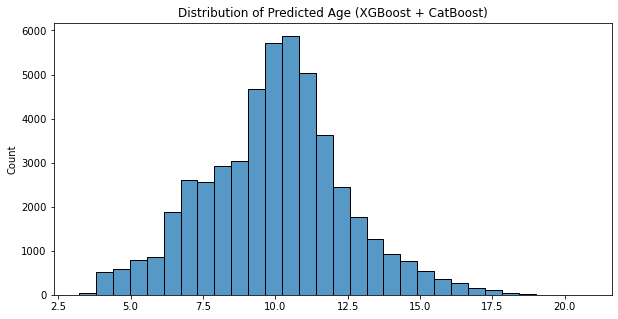

In [50]:
plt.figure(figsize=(10, 5))
sns.histplot(y_test_pred , bins=30)
plt.title('Distribution of Predicted Age (XGBoost + CatBoost)')
plt.show()

In [51]:
submission = pd.DataFrame({
    'id': test_ids,
    'Age': y_test_pred
})
submission.to_csv("voting_model_2.csv", index = False)

In [52]:
voting_model = VotingRegressor([
    ('lgbm', lgbm_random_search.best_estimator_),
    ('cat', cat_random_search.best_estimator_)
])

# Fit the model to the training data
voting_model.fit(X, y)

# Make predictions on the validation data
y_test_pred = voting_model.predict(X_test)

0:	learn: 3.0347244	total: 3.39ms	remaining: 1.69s
1:	learn: 2.9150194	total: 6.8ms	remaining: 1.69s
2:	learn: 2.8136279	total: 9.59ms	remaining: 1.59s
3:	learn: 2.7245288	total: 12.7ms	remaining: 1.57s
4:	learn: 2.6473998	total: 15.4ms	remaining: 1.53s
5:	learn: 2.5784715	total: 18.2ms	remaining: 1.5s
6:	learn: 2.5208206	total: 21.1ms	remaining: 1.48s
7:	learn: 2.4736330	total: 23.8ms	remaining: 1.46s
8:	learn: 2.4306330	total: 26.4ms	remaining: 1.44s
9:	learn: 2.3947097	total: 29.1ms	remaining: 1.43s
10:	learn: 2.3649478	total: 31.7ms	remaining: 1.41s
11:	learn: 2.3376804	total: 34.3ms	remaining: 1.4s
12:	learn: 2.3140121	total: 37.2ms	remaining: 1.39s
13:	learn: 2.2918311	total: 40.2ms	remaining: 1.4s
14:	learn: 2.2737092	total: 43ms	remaining: 1.39s
15:	learn: 2.2548710	total: 45.6ms	remaining: 1.38s
16:	learn: 2.2415349	total: 48.4ms	remaining: 1.37s
17:	learn: 2.2292715	total: 51.1ms	remaining: 1.37s
18:	learn: 2.2176300	total: 53.8ms	remaining: 1.36s
19:	learn: 2.2077698	total: 

187:	learn: 2.0274859	total: 528ms	remaining: 876ms
188:	learn: 2.0274652	total: 530ms	remaining: 873ms
189:	learn: 2.0271899	total: 533ms	remaining: 870ms
190:	learn: 2.0271700	total: 537ms	remaining: 868ms
191:	learn: 2.0268296	total: 540ms	remaining: 866ms
192:	learn: 2.0265615	total: 543ms	remaining: 864ms
193:	learn: 2.0265420	total: 545ms	remaining: 860ms
194:	learn: 2.0262667	total: 548ms	remaining: 857ms
195:	learn: 2.0260074	total: 550ms	remaining: 854ms
196:	learn: 2.0259886	total: 553ms	remaining: 850ms
197:	learn: 2.0256052	total: 555ms	remaining: 847ms
198:	learn: 2.0254038	total: 558ms	remaining: 844ms
199:	learn: 2.0250145	total: 561ms	remaining: 841ms
200:	learn: 2.0246580	total: 564ms	remaining: 839ms
201:	learn: 2.0243389	total: 567ms	remaining: 836ms
202:	learn: 2.0240347	total: 570ms	remaining: 834ms
203:	learn: 2.0238235	total: 572ms	remaining: 830ms
204:	learn: 2.0234769	total: 575ms	remaining: 828ms
205:	learn: 2.0231207	total: 578ms	remaining: 826ms
206:	learn: 

383:	learn: 1.9944673	total: 1.06s	remaining: 319ms
384:	learn: 1.9942936	total: 1.06s	remaining: 317ms
385:	learn: 1.9941120	total: 1.06s	remaining: 314ms
386:	learn: 1.9940771	total: 1.07s	remaining: 311ms
387:	learn: 1.9939516	total: 1.07s	remaining: 308ms
388:	learn: 1.9939399	total: 1.07s	remaining: 306ms
389:	learn: 1.9936854	total: 1.07s	remaining: 303ms
390:	learn: 1.9934702	total: 1.08s	remaining: 300ms
391:	learn: 1.9933457	total: 1.08s	remaining: 297ms
392:	learn: 1.9931292	total: 1.08s	remaining: 295ms
393:	learn: 1.9929603	total: 1.08s	remaining: 292ms
394:	learn: 1.9928418	total: 1.09s	remaining: 289ms
395:	learn: 1.9926764	total: 1.09s	remaining: 286ms
396:	learn: 1.9925249	total: 1.09s	remaining: 284ms
397:	learn: 1.9923648	total: 1.09s	remaining: 281ms
398:	learn: 1.9921961	total: 1.1s	remaining: 278ms
399:	learn: 1.9921049	total: 1.1s	remaining: 275ms
400:	learn: 1.9919613	total: 1.1s	remaining: 272ms
401:	learn: 1.9917914	total: 1.11s	remaining: 270ms
402:	learn: 1.9

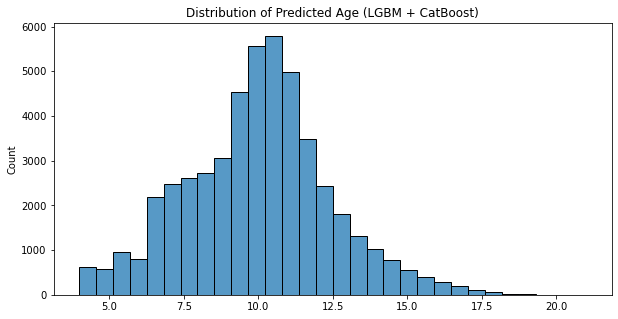

In [53]:
plt.figure(figsize=(10, 5))
sns.histplot(y_test_pred , bins=30)
plt.title('Distribution of Predicted Age (LGBM + CatBoost)')
plt.show()

In [54]:
submission = pd.DataFrame({
    'id': test_ids,
    'Age': y_test_pred
})
submission.to_csv("voting_model_3.csv", index = False)

### New Features + Automl Library

In [69]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, should_add_features=True):
        self.should_add_features = should_add_features

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        processed_data = X.copy()

        if self.should_add_features:
            processed_data["H*D"] = processed_data["Height"] * processed_data["Diameter"]
            processed_data["H*L"] = processed_data["Height"] * processed_data["Length"]
            processed_data["D*L"] = processed_data["Diameter"] * processed_data["Length"]
            processed_data["V"] = processed_data["Height"] * processed_data["Diameter"] * processed_data["Length"]

            processed_data["weight_sum"] = processed_data["Shell Weight"] + processed_data["Viscera Weight"] + processed_data["Shucked Weight"]
            processed_data["weight_volume_ratio"] = processed_data["Weight"] / (processed_data["Diameter"] + 1e-8)
            processed_data["shell/weight"] = processed_data["Shell Weight"] / processed_data["Weight"]
            processed_data["viscera/weight"] = processed_data["Viscera Weight"] / processed_data["Weight"]
            processed_data["shucked/weight"] = processed_data["Shucked Weight"] / processed_data["Weight"]
            
            
        return processed_data

In [70]:
Creator = FeatureEngineer(should_add_features = True)

In [71]:
automl = AutoML()

In [72]:
# Autmol hyperparamters setting
automl_settings = {
    "time_budget": 10800,  # total running time in seconds
    "task": 'regression',  # task type
    "seed": 24545678,  # random seed
    "metric" : 'mae',
    "eval_method" : 'cv',
    "n_splits" : 7,
    "ensemble" : True,
        "ensemble": {
        "final_estimator": LADRegression(),
        "passthrough": True,
         "n_estimators": 100,  # number of estimators for ensemble
        "learning_rate": 0.1 # learning rate for boosting
    },
    
}

pipeline_settings = {f"automl__{key}": value for key, value in automl_settings.items()}

In [73]:
automl_pipeline = Pipeline([
    ('Creator', Creator),
    ('preprocessor', preprocessor),
    ("automl", automl)
])
automl_pipeline

Pipeline(steps=[('Creator', FeatureEngineer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Weight',
                                                   'Shucked Weight',
                                                   'Viscera Weight',
                                                   'Shell Weight']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex'])])),
                ('automl',
                 AutoML(append_log=False, auto_augment=True, custom_hp={},
                        cv_score_agg_func=None, early_stop=False,
                        ensem...
                        keep_search_state=False, learner_selector='sample',
                        log_file_name='', log_training_metric=False,
                        log_type='better', max_iter=None, mem_thres=4294967296,
                        metric='auto', metric_constraints=[],
                        min_sample_size=10000, mlflow_logging=True,
                        model_history=False, n_concurrent_trials=1, n_jobs=-1,
                        n_splits=5, pred_time_limit=inf,
                        preserve_checkpoint=True, retrain_full=True, ...))])

In [74]:
automl_pipeline = automl_pipeline.fit(X, y, **pipeline_settings)

[flaml.automl.logger: 06-14 16:10:24] {1693} INFO - task = regression
[flaml.automl.logger: 06-14 16:10:24] {1700} INFO - Data split method: uniform
[flaml.automl.logger: 06-14 16:10:24] {1703} INFO - Evaluation method: cv
[flaml.automl.logger: 06-14 16:10:24] {1801} INFO - Minimizing error metric: mae
[flaml.automl.logger: 06-14 16:10:24] {1911} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 06-14 16:10:24] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-14 16:10:25] {2347} INFO - Estimated sufficient time budget=2214s. Estimated necessary time budget=19s.
[flaml.automl.logger: 06-14 16:10:25] {2394} INFO -  at 0.2s,	estimator lgbm's best error=2.0030,	best estimator lgbm's best error=2.0030
[flaml.automl.logger: 06-14 16:10:25] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-14 16:10:25] {2394} INFO -  at 0.5s,	estimator lgbm's best error=2.0030,	be

[flaml.automl.logger: 06-14 16:10:39] {2394} INFO -  at 14.4s,	estimator extra_tree's best error=1.5691,	best estimator xgboost's best error=1.4025
[flaml.automl.logger: 06-14 16:10:39] {2221} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 06-14 16:10:39] {2394} INFO -  at 14.6s,	estimator lgbm's best error=1.4112,	best estimator xgboost's best error=1.4025
[flaml.automl.logger: 06-14 16:10:39] {2221} INFO - iteration 35, current learner xgboost
[flaml.automl.logger: 06-14 16:10:39] {2394} INFO -  at 15.0s,	estimator xgboost's best error=1.4025,	best estimator xgboost's best error=1.4025
[flaml.automl.logger: 06-14 16:10:39] {2221} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 06-14 16:10:40] {2394} INFO -  at 15.8s,	estimator extra_tree's best error=1.5691,	best estimator xgboost's best error=1.4025
[flaml.automl.logger: 06-14 16:10:40] {2221} INFO - iteration 37, current learner xgboost
[flaml.automl.logger: 06-14 16:10:41] {2394} INFO -  at 1

[flaml.automl.logger: 06-14 16:11:19] {2221} INFO - iteration 69, current learner lgbm
[flaml.automl.logger: 06-14 16:11:20] {2394} INFO -  at 55.5s,	estimator lgbm's best error=1.4036,	best estimator xgboost's best error=1.4025
[flaml.automl.logger: 06-14 16:11:20] {2221} INFO - iteration 70, current learner xgboost
[flaml.automl.logger: 06-14 16:11:20] {2394} INFO -  at 55.7s,	estimator xgboost's best error=1.4025,	best estimator xgboost's best error=1.4025
[flaml.automl.logger: 06-14 16:11:20] {2221} INFO - iteration 71, current learner xgboost
[flaml.automl.logger: 06-14 16:11:21] {2394} INFO -  at 57.0s,	estimator xgboost's best error=1.4017,	best estimator xgboost's best error=1.4017
[flaml.automl.logger: 06-14 16:11:21] {2221} INFO - iteration 72, current learner catboost
[flaml.automl.logger: 06-14 16:11:24] {2394} INFO -  at 59.9s,	estimator catboost's best error=1.4181,	best estimator xgboost's best error=1.4017
[flaml.automl.logger: 06-14 16:11:24] {2221} INFO - iteration 73

[flaml.automl.logger: 06-14 16:12:55] {2394} INFO -  at 150.5s,	estimator catboost's best error=1.4166,	best estimator xgboost's best error=1.4017
[flaml.automl.logger: 06-14 16:12:55] {2221} INFO - iteration 105, current learner rf
[flaml.automl.logger: 06-14 16:12:57] {2394} INFO -  at 152.2s,	estimator rf's best error=1.4155,	best estimator xgboost's best error=1.4017
[flaml.automl.logger: 06-14 16:12:57] {2221} INFO - iteration 106, current learner rf
[flaml.automl.logger: 06-14 16:12:58] {2394} INFO -  at 154.1s,	estimator rf's best error=1.4155,	best estimator xgboost's best error=1.4017
[flaml.automl.logger: 06-14 16:12:58] {2221} INFO - iteration 107, current learner extra_tree
[flaml.automl.logger: 06-14 16:12:59] {2394} INFO -  at 154.8s,	estimator extra_tree's best error=1.4209,	best estimator xgboost's best error=1.4017
[flaml.automl.logger: 06-14 16:12:59] {2221} INFO - iteration 108, current learner rf
[flaml.automl.logger: 06-14 16:13:01] {2394} INFO -  at 157.0s,	estima

[flaml.automl.logger: 06-14 16:14:13] {2394} INFO -  at 228.7s,	estimator extra_tree's best error=1.4174,	best estimator lgbm's best error=1.3997
[flaml.automl.logger: 06-14 16:14:13] {2221} INFO - iteration 140, current learner rf
[flaml.automl.logger: 06-14 16:14:16] {2394} INFO -  at 231.7s,	estimator rf's best error=1.4155,	best estimator lgbm's best error=1.3997
[flaml.automl.logger: 06-14 16:14:16] {2221} INFO - iteration 141, current learner extra_tree
[flaml.automl.logger: 06-14 16:14:25] {2394} INFO -  at 240.5s,	estimator extra_tree's best error=1.4156,	best estimator lgbm's best error=1.3997
[flaml.automl.logger: 06-14 16:14:25] {2221} INFO - iteration 142, current learner rf
[flaml.automl.logger: 06-14 16:14:26] {2394} INFO -  at 241.3s,	estimator rf's best error=1.4155,	best estimator lgbm's best error=1.3997
[flaml.automl.logger: 06-14 16:14:26] {2221} INFO - iteration 143, current learner extra_tree
[flaml.automl.logger: 06-14 16:14:37] {2394} INFO -  at 252.4s,	estimato

[flaml.automl.logger: 06-14 16:16:35] {2394} INFO -  at 370.7s,	estimator xgb_limitdepth's best error=1.3823,	best estimator xgb_limitdepth's best error=1.3823
[flaml.automl.logger: 06-14 16:16:35] {2221} INFO - iteration 175, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:16:35] {2394} INFO -  at 371.0s,	estimator xgb_limitdepth's best error=1.3823,	best estimator xgb_limitdepth's best error=1.3823
[flaml.automl.logger: 06-14 16:16:35] {2221} INFO - iteration 176, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:16:38] {2394} INFO -  at 373.7s,	estimator xgb_limitdepth's best error=1.3823,	best estimator xgb_limitdepth's best error=1.3823
[flaml.automl.logger: 06-14 16:16:38] {2221} INFO - iteration 177, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:16:39] {2394} INFO -  at 374.6s,	estimator xgb_limitdepth's best error=1.3823,	best estimator xgb_limitdepth's best error=1.3823
[flaml.automl.logger: 06-14 16:16:39] {2221} INFO - iteration 178,

[flaml.automl.logger: 06-14 16:18:19] {2221} INFO - iteration 208, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:18:19] {2394} INFO -  at 474.9s,	estimator xgb_limitdepth's best error=1.3823,	best estimator xgboost's best error=1.3821
[flaml.automl.logger: 06-14 16:18:19] {2221} INFO - iteration 209, current learner extra_tree
[flaml.automl.logger: 06-14 16:18:27] {2394} INFO -  at 482.4s,	estimator extra_tree's best error=1.4140,	best estimator xgboost's best error=1.3821
[flaml.automl.logger: 06-14 16:18:27] {2221} INFO - iteration 210, current learner xgboost
[flaml.automl.logger: 06-14 16:18:28] {2394} INFO -  at 483.3s,	estimator xgboost's best error=1.3821,	best estimator xgboost's best error=1.3821
[flaml.automl.logger: 06-14 16:18:28] {2221} INFO - iteration 211, current learner xgboost
[flaml.automl.logger: 06-14 16:18:41] {2394} INFO -  at 497.1s,	estimator xgboost's best error=1.3821,	best estimator xgboost's best error=1.3821
[flaml.automl.logger: 06-14 16:1

[flaml.automl.logger: 06-14 16:20:42] {2394} INFO -  at 617.3s,	estimator lgbm's best error=1.3997,	best estimator xgboost's best error=1.3821
[flaml.automl.logger: 06-14 16:20:42] {2221} INFO - iteration 243, current learner extra_tree
[flaml.automl.logger: 06-14 16:20:45] {2394} INFO -  at 620.8s,	estimator extra_tree's best error=1.4140,	best estimator xgboost's best error=1.3821
[flaml.automl.logger: 06-14 16:20:45] {2221} INFO - iteration 244, current learner xgboost
[flaml.automl.logger: 06-14 16:20:47] {2394} INFO -  at 622.5s,	estimator xgboost's best error=1.3821,	best estimator xgboost's best error=1.3821
[flaml.automl.logger: 06-14 16:20:47] {2221} INFO - iteration 245, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:20:47] {2394} INFO -  at 622.9s,	estimator xgb_limitdepth's best error=1.3823,	best estimator xgboost's best error=1.3821
[flaml.automl.logger: 06-14 16:20:47] {2221} INFO - iteration 246, current learner catboost
[flaml.automl.logger: 06-14 16:20:

[flaml.automl.logger: 06-14 16:23:56] {2394} INFO -  at 811.2s,	estimator catboost's best error=1.4143,	best estimator xgboost's best error=1.3821
[flaml.automl.logger: 06-14 16:23:56] {2221} INFO - iteration 277, current learner catboost
[flaml.automl.logger: 06-14 16:24:01] {2394} INFO -  at 817.0s,	estimator catboost's best error=1.4143,	best estimator xgboost's best error=1.3821
[flaml.automl.logger: 06-14 16:24:01] {2221} INFO - iteration 278, current learner extra_tree
[flaml.automl.logger: 06-14 16:24:08] {2394} INFO -  at 824.1s,	estimator extra_tree's best error=1.4140,	best estimator xgboost's best error=1.3821
[flaml.automl.logger: 06-14 16:24:08] {2221} INFO - iteration 279, current learner xgboost
[flaml.automl.logger: 06-14 16:24:10] {2394} INFO -  at 825.7s,	estimator xgboost's best error=1.3821,	best estimator xgboost's best error=1.3821
[flaml.automl.logger: 06-14 16:24:10] {2221} INFO - iteration 280, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:24:10

[flaml.automl.logger: 06-14 16:26:28] {2221} INFO - iteration 311, current learner xgboost
[flaml.automl.logger: 06-14 16:26:45] {2394} INFO -  at 981.0s,	estimator xgboost's best error=1.3717,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:26:45] {2221} INFO - iteration 312, current learner xgboost
[flaml.automl.logger: 06-14 16:26:47] {2394} INFO -  at 982.6s,	estimator xgboost's best error=1.3717,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:26:47] {2221} INFO - iteration 313, current learner rf
[flaml.automl.logger: 06-14 16:26:49] {2394} INFO -  at 984.6s,	estimator rf's best error=1.4096,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:26:49] {2221} INFO - iteration 314, current learner xgboost
[flaml.automl.logger: 06-14 16:26:58] {2394} INFO -  at 993.6s,	estimator xgboost's best error=1.3717,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:26:58] {2221} INFO - iteration 

[flaml.automl.logger: 06-14 16:30:18] {2394} INFO -  at 1193.8s,	estimator xgboost's best error=1.3717,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:30:18] {2221} INFO - iteration 346, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:30:21] {2394} INFO -  at 1196.7s,	estimator xgb_limitdepth's best error=1.3823,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:30:21] {2221} INFO - iteration 347, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:30:22] {2394} INFO -  at 1197.2s,	estimator xgb_limitdepth's best error=1.3823,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:30:22] {2221} INFO - iteration 348, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:30:23] {2394} INFO -  at 1198.8s,	estimator xgb_limitdepth's best error=1.3823,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:30:23] {2221} INFO - iteration 349, current learner xgb_limitdepth

[flaml.automl.logger: 06-14 16:33:15] {2394} INFO -  at 1371.0s,	estimator xgb_limitdepth's best error=1.3823,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:33:15] {2221} INFO - iteration 380, current learner lgbm
[flaml.automl.logger: 06-14 16:33:17] {2394} INFO -  at 1372.2s,	estimator lgbm's best error=1.3986,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:33:17] {2221} INFO - iteration 381, current learner catboost
[flaml.automl.logger: 06-14 16:33:20] {2394} INFO -  at 1375.9s,	estimator catboost's best error=1.4143,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:33:20] {2221} INFO - iteration 382, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:33:21] {2394} INFO -  at 1376.4s,	estimator xgb_limitdepth's best error=1.3823,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:33:21] {2221} INFO - iteration 383, current learner extra_tree
[flaml.automl.logger: 06-14 

[flaml.automl.logger: 06-14 16:37:54] {2221} INFO - iteration 414, current learner lgbm
[flaml.automl.logger: 06-14 16:37:55] {2394} INFO -  at 1651.0s,	estimator lgbm's best error=1.3982,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:37:55] {2221} INFO - iteration 415, current learner rf
[flaml.automl.logger: 06-14 16:38:06] {2394} INFO -  at 1662.1s,	estimator rf's best error=1.4092,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:38:06] {2221} INFO - iteration 416, current learner lgbm
[flaml.automl.logger: 06-14 16:38:11] {2394} INFO -  at 1666.8s,	estimator lgbm's best error=1.3982,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:38:11] {2221} INFO - iteration 417, current learner xgboost
[flaml.automl.logger: 06-14 16:38:20] {2394} INFO -  at 1675.7s,	estimator xgboost's best error=1.3717,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:38:20] {2221} INFO - iteration 418, cur

[flaml.automl.logger: 06-14 16:43:29] {2221} INFO - iteration 449, current learner lgbm
[flaml.automl.logger: 06-14 16:43:39] {2394} INFO -  at 1994.9s,	estimator lgbm's best error=1.3981,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:43:39] {2221} INFO - iteration 450, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:43:40] {2394} INFO -  at 1995.4s,	estimator xgb_limitdepth's best error=1.3823,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:43:40] {2221} INFO - iteration 451, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:43:41] {2394} INFO -  at 1996.8s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:43:41] {2221} INFO - iteration 452, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:43:42] {2394} INFO -  at 1997.5s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3717
[flaml.autom

[flaml.automl.logger: 06-14 16:48:27] {2221} INFO - iteration 483, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:48:29] {2394} INFO -  at 2284.2s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:48:29] {2221} INFO - iteration 484, current learner lgbm
[flaml.automl.logger: 06-14 16:48:38] {2394} INFO -  at 2293.9s,	estimator lgbm's best error=1.3965,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:48:38] {2221} INFO - iteration 485, current learner xgboost
[flaml.automl.logger: 06-14 16:48:43] {2394} INFO -  at 2298.4s,	estimator xgboost's best error=1.3717,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:48:43] {2221} INFO - iteration 486, current learner rf
[flaml.automl.logger: 06-14 16:49:06] {2394} INFO -  at 2321.3s,	estimator rf's best error=1.4079,	best estimator xgboost's best error=1.3717
[flaml.automl.logger: 06-14 16:49:06] {2221} INFO 

[flaml.automl.logger: 06-14 16:53:13] {2394} INFO -  at 2568.4s,	estimator catboost's best error=1.4143,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 16:53:13] {2221} INFO - iteration 518, current learner lgbm
[flaml.automl.logger: 06-14 16:53:24] {2394} INFO -  at 2579.5s,	estimator lgbm's best error=1.3965,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 16:53:24] {2221} INFO - iteration 519, current learner rf
[flaml.automl.logger: 06-14 16:53:32] {2394} INFO -  at 2587.4s,	estimator rf's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 16:53:32] {2221} INFO - iteration 520, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:53:33] {2394} INFO -  at 2588.5s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 16:53:33] {2221} INFO - iteration 521, current learner xgboost
[flaml.automl.logger: 06-14 16:53:39] {2394} INFO

[flaml.automl.logger: 06-14 16:59:38] {2394} INFO -  at 2953.4s,	estimator lgbm's best error=1.3965,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 16:59:38] {2221} INFO - iteration 552, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:59:39] {2394} INFO -  at 2955.1s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 16:59:39] {2221} INFO - iteration 553, current learner catboost
[flaml.automl.logger: 06-14 16:59:45] {2394} INFO -  at 2960.2s,	estimator catboost's best error=1.4143,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 16:59:45] {2221} INFO - iteration 554, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 16:59:49] {2394} INFO -  at 2964.6s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 16:59:49] {2221} INFO - iteration 555, current learner rf
[flaml.automl.logger: 06-1

[flaml.automl.logger: 06-14 17:04:32] {2221} INFO - iteration 585, current learner xgboost
[flaml.automl.logger: 06-14 17:05:55] {2394} INFO -  at 3331.1s,	estimator xgboost's best error=1.3707,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:05:55] {2221} INFO - iteration 586, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:05:56] {2394} INFO -  at 3331.6s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:05:56] {2221} INFO - iteration 587, current learner rf
[flaml.automl.logger: 06-14 17:06:04] {2394} INFO -  at 3339.6s,	estimator rf's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:06:04] {2221} INFO - iteration 588, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:06:13] {2394} INFO -  at 3348.6s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17

[flaml.automl.logger: 06-14 17:10:15] {2221} INFO - iteration 619, current learner catboost
[flaml.automl.logger: 06-14 17:10:21] {2394} INFO -  at 3596.2s,	estimator catboost's best error=1.4127,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:10:21] {2221} INFO - iteration 620, current learner catboost
[flaml.automl.logger: 06-14 17:10:37] {2394} INFO -  at 3612.8s,	estimator catboost's best error=1.4127,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:10:37] {2221} INFO - iteration 621, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:10:38] {2394} INFO -  at 3613.7s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:10:38] {2221} INFO - iteration 622, current learner catboost
[flaml.automl.logger: 06-14 17:10:43] {2394} INFO -  at 3619.0s,	estimator catboost's best error=1.4127,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 

[flaml.automl.logger: 06-14 17:15:51] {2221} INFO - iteration 653, current learner rf
[flaml.automl.logger: 06-14 17:15:57] {2394} INFO -  at 3932.7s,	estimator rf's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:15:57] {2221} INFO - iteration 654, current learner catboost
[flaml.automl.logger: 06-14 17:16:01] {2394} INFO -  at 3936.9s,	estimator catboost's best error=1.4096,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:16:01] {2221} INFO - iteration 655, current learner catboost
[flaml.automl.logger: 06-14 17:16:08] {2394} INFO -  at 3943.9s,	estimator catboost's best error=1.4086,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:16:08] {2221} INFO - iteration 656, current learner catboost
[flaml.automl.logger: 06-14 17:16:14] {2394} INFO -  at 3949.4s,	estimator catboost's best error=1.4086,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:16:14] {2221} INFO - 

[flaml.automl.logger: 06-14 17:22:28] {2221} INFO - iteration 687, current learner catboost
[flaml.automl.logger: 06-14 17:22:35] {2394} INFO -  at 4330.3s,	estimator catboost's best error=1.4086,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:22:35] {2221} INFO - iteration 688, current learner extra_tree
[flaml.automl.logger: 06-14 17:22:47] {2394} INFO -  at 4342.7s,	estimator extra_tree's best error=1.4134,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:22:47] {2221} INFO - iteration 689, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:22:49] {2394} INFO -  at 4344.2s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:22:49] {2221} INFO - iteration 690, current learner catboost
[flaml.automl.logger: 06-14 17:22:58] {2394} INFO -  at 4353.2s,	estimator catboost's best error=1.4086,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06

[flaml.automl.logger: 06-14 17:26:39] {2221} INFO - iteration 721, current learner catboost
[flaml.automl.logger: 06-14 17:26:47] {2394} INFO -  at 4582.2s,	estimator catboost's best error=1.4086,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:26:47] {2221} INFO - iteration 722, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:26:57] {2394} INFO -  at 4592.6s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:26:57] {2221} INFO - iteration 723, current learner catboost
[flaml.automl.logger: 06-14 17:27:01] {2394} INFO -  at 4597.0s,	estimator catboost's best error=1.4086,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:27:01] {2221} INFO - iteration 724, current learner extra_tree
[flaml.automl.logger: 06-14 17:27:08] {2394} INFO -  at 4603.8s,	estimator extra_tree's best error=1.4134,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06

[flaml.automl.logger: 06-14 17:31:54] {2221} INFO - iteration 755, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:31:58] {2394} INFO -  at 4893.3s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:31:58] {2221} INFO - iteration 756, current learner xgboost
[flaml.automl.logger: 06-14 17:32:15] {2394} INFO -  at 4910.9s,	estimator xgboost's best error=1.3707,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:32:15] {2221} INFO - iteration 757, current learner rf
[flaml.automl.logger: 06-14 17:32:41] {2394} INFO -  at 4936.7s,	estimator rf's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:32:41] {2221} INFO - iteration 758, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:32:44] {2394} INFO -  at 4939.5s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17

[flaml.automl.logger: 06-14 17:37:51] {2221} INFO - iteration 789, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:37:52] {2394} INFO -  at 5248.0s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:37:52] {2221} INFO - iteration 790, current learner extra_tree
[flaml.automl.logger: 06-14 17:38:07] {2394} INFO -  at 5262.9s,	estimator extra_tree's best error=1.4134,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:38:07] {2221} INFO - iteration 791, current learner catboost
[flaml.automl.logger: 06-14 17:38:16] {2394} INFO -  at 5271.8s,	estimator catboost's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:38:16] {2221} INFO - iteration 792, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:38:22] {2394} INFO -  at 5277.4s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.autom

[flaml.automl.logger: 06-14 17:41:39] {2221} INFO - iteration 823, current learner rf
[flaml.automl.logger: 06-14 17:41:49] {2394} INFO -  at 5484.7s,	estimator rf's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:41:49] {2221} INFO - iteration 824, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:41:50] {2394} INFO -  at 5485.9s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:41:50] {2221} INFO - iteration 825, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:41:55] {2394} INFO -  at 5490.8s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:41:55] {2221} INFO - iteration 826, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:41:58] {2394} INFO -  at 5494.1s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.lo

[flaml.automl.logger: 06-14 17:47:40] {2394} INFO -  at 5835.6s,	estimator xgb_limitdepth's best error=1.3774,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:47:40] {2221} INFO - iteration 858, current learner extra_tree
[flaml.automl.logger: 06-14 17:47:48] {2394} INFO -  at 5843.7s,	estimator extra_tree's best error=1.4134,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:47:48] {2221} INFO - iteration 859, current learner rf
[flaml.automl.logger: 06-14 17:47:59] {2394} INFO -  at 5854.5s,	estimator rf's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:47:59] {2221} INFO - iteration 860, current learner xgboost
[flaml.automl.logger: 06-14 17:48:02] {2394} INFO -  at 5857.7s,	estimator xgboost's best error=1.3707,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:48:02] {2221} INFO - iteration 861, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:48:06] 

[flaml.automl.logger: 06-14 17:54:57] {2394} INFO -  at 6273.1s,	estimator xgb_limitdepth's best error=1.3749,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:54:57] {2221} INFO - iteration 892, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:55:00] {2394} INFO -  at 6275.3s,	estimator xgb_limitdepth's best error=1.3749,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:55:00] {2221} INFO - iteration 893, current learner lgbm
[flaml.automl.logger: 06-14 17:55:21] {2394} INFO -  at 6297.1s,	estimator lgbm's best error=1.3965,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:55:21] {2221} INFO - iteration 894, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 17:55:26] {2394} INFO -  at 6301.4s,	estimator xgb_limitdepth's best error=1.3749,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 17:55:26] {2221} INFO - iteration 895, current learner xgboost
[flaml.automl.logge

[flaml.automl.logger: 06-14 18:00:27] {2221} INFO - iteration 925, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 18:00:30] {2394} INFO -  at 6606.0s,	estimator xgb_limitdepth's best error=1.3749,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:00:30] {2221} INFO - iteration 926, current learner catboost
[flaml.automl.logger: 06-14 18:00:37] {2394} INFO -  at 6613.0s,	estimator catboost's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:00:37] {2221} INFO - iteration 927, current learner xgboost
[flaml.automl.logger: 06-14 18:01:33] {2394} INFO -  at 6668.4s,	estimator xgboost's best error=1.3707,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:01:33] {2221} INFO - iteration 928, current learner catboost
[flaml.automl.logger: 06-14 18:01:37] {2394} INFO -  at 6673.1s,	estimator catboost's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18

[flaml.automl.logger: 06-14 18:08:05] {2221} INFO - iteration 959, current learner rf
[flaml.automl.logger: 06-14 18:08:48] {2394} INFO -  at 7103.3s,	estimator rf's best error=1.4070,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:08:48] {2221} INFO - iteration 960, current learner lgbm
[flaml.automl.logger: 06-14 18:08:50] {2394} INFO -  at 7105.6s,	estimator lgbm's best error=1.3965,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:08:50] {2221} INFO - iteration 961, current learner rf
[flaml.automl.logger: 06-14 18:09:01] {2394} INFO -  at 7116.8s,	estimator rf's best error=1.4070,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:09:01] {2221} INFO - iteration 962, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 18:09:04] {2394} INFO -  at 7119.7s,	estimator xgb_limitdepth's best error=1.3749,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:09:04] {2221} INFO - iteratio

[flaml.automl.logger: 06-14 18:26:14] {2394} INFO -  at 8149.5s,	estimator rf's best error=1.4063,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:26:14] {2221} INFO - iteration 994, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 18:26:17] {2394} INFO -  at 8152.6s,	estimator xgb_limitdepth's best error=1.3749,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:26:17] {2221} INFO - iteration 995, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 18:26:20] {2394} INFO -  at 8156.1s,	estimator xgb_limitdepth's best error=1.3749,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:26:20] {2221} INFO - iteration 996, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 18:26:22] {2394} INFO -  at 8158.1s,	estimator xgb_limitdepth's best error=1.3749,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:26:22] {2221} INFO - iteration 997, current learner catboost
[flaml.aut

[flaml.automl.logger: 06-14 18:34:42] {2394} INFO -  at 8657.9s,	estimator extra_tree's best error=1.4134,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:34:42] {2221} INFO - iteration 1028, current learner catboost
[flaml.automl.logger: 06-14 18:34:53] {2394} INFO -  at 8669.0s,	estimator catboost's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:34:53] {2221} INFO - iteration 1029, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 18:34:57] {2394} INFO -  at 8672.7s,	estimator xgb_limitdepth's best error=1.3749,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:34:57] {2221} INFO - iteration 1030, current learner catboost
[flaml.automl.logger: 06-14 18:35:01] {2394} INFO -  at 8677.1s,	estimator catboost's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:35:01] {2221} INFO - iteration 1031, current learner lgbm
[flaml.automl.logger: 06-1

[flaml.automl.logger: 06-14 18:43:26] {2221} INFO - iteration 1061, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 18:43:28] {2394} INFO -  at 9183.2s,	estimator xgb_limitdepth's best error=1.3749,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:43:28] {2221} INFO - iteration 1062, current learner extra_tree
[flaml.automl.logger: 06-14 18:43:50] {2394} INFO -  at 9205.3s,	estimator extra_tree's best error=1.4134,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:43:50] {2221} INFO - iteration 1063, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 18:43:53] {2394} INFO -  at 9208.2s,	estimator xgb_limitdepth's best error=1.3749,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:43:53] {2221} INFO - iteration 1064, current learner catboost
[flaml.automl.logger: 06-14 18:44:03] {2394} INFO -  at 9218.8s,	estimator catboost's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.a

[flaml.automl.logger: 06-14 18:54:00] {2221} INFO - iteration 1095, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 18:54:02] {2394} INFO -  at 9817.7s,	estimator xgb_limitdepth's best error=1.3728,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:54:02] {2221} INFO - iteration 1096, current learner extra_tree
[flaml.automl.logger: 06-14 18:54:17] {2394} INFO -  at 9833.1s,	estimator extra_tree's best error=1.4134,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:54:17] {2221} INFO - iteration 1097, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 18:54:37] {2394} INFO -  at 9852.8s,	estimator xgb_limitdepth's best error=1.3728,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 18:54:37] {2221} INFO - iteration 1098, current learner catboost
[flaml.automl.logger: 06-14 18:54:50] {2394} INFO -  at 9865.4s,	estimator catboost's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.a

[flaml.automl.logger: 06-14 19:03:13] {2221} INFO - iteration 1129, current learner extra_tree
[flaml.automl.logger: 06-14 19:03:39] {2394} INFO -  at 10394.2s,	estimator extra_tree's best error=1.4134,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 19:03:39] {2221} INFO - iteration 1130, current learner catboost
[flaml.automl.logger: 06-14 19:03:44] {2394} INFO -  at 10399.6s,	estimator catboost's best error=1.4079,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 19:03:44] {2221} INFO - iteration 1131, current learner xgb_limitdepth
[flaml.automl.logger: 06-14 19:03:47] {2394} INFO -  at 10402.5s,	estimator xgb_limitdepth's best error=1.3728,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 19:03:47] {2221} INFO - iteration 1132, current learner extra_tree
[flaml.automl.logger: 06-14 19:03:55] {2394} INFO -  at 10410.2s,	estimator extra_tree's best error=1.4134,	best estimator xgboost's best error=1.3707
[flaml.autom

[flaml.automl.logger: 06-14 19:10:25] {2394} INFO -  at 10800.6s,	estimator xgboost's best error=1.3707,	best estimator xgboost's best error=1.3707
[flaml.automl.logger: 06-14 19:10:25] {2528} INFO - [('xgboost', {'n_jobs': -1, 'n_estimators': 356, 'max_leaves': 157, 'min_child_weight': 3.438760316024106, 'learning_rate': 0.009468208918138937, 'subsample': 0.8314279246459502, 'colsample_bylevel': 0.740145942609568, 'colsample_bytree': 0.8414420132116449, 'reg_alpha': 0.002175858121259013, 'reg_lambda': 0.7508730964894378, 'max_depth': 0, 'grow_policy': 'lossguide', 'tree_method': 'hist', 'use_label_encoder': False, 'verbosity': 0}), ('xgb_limitdepth', {'n_jobs': -1, 'n_estimators': 56, 'max_depth': 9, 'min_child_weight': 26.163070322826602, 'learning_rate': 0.06253502144015984, 'subsample': 1.0, 'colsample_bylevel': 0.694723770993311, 'colsample_bytree': 0.9357967886336109, 'reg_alpha': 0.0024074672044445715, 'reg_lambda': 1.55868256014548, 'use_label_encoder': False, 'verbosity': 0}),

In [81]:
preds_test =  automl_pipeline.predict(test)

In [82]:
preds_test = [round(x) for x in preds_test]

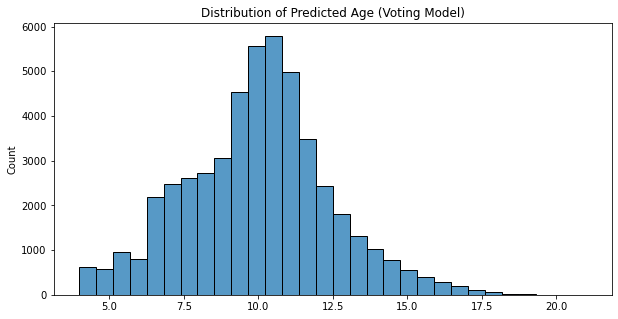

In [79]:
plt.figure(figsize=(10, 5))
sns.histplot(y_test_pred , bins=30)
plt.title('Distribution of Predicted Age (New features + Automl)')
plt.show()

In [80]:
output = pd.DataFrame({'id': test_ids,
                       'Age': preds_test})
output.to_csv('submission.csv', index=False)

### Next Step

Since the features are highly correlated with each other, PCA might work well.
Learn the concept of PCA